### Домашнее задание № 20
#### Козел А.Г.
08.01.2023

Работа с временными рядами.
    
Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)


In [2]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv') 

Text(0, 0.5, 'Accidental deaths')

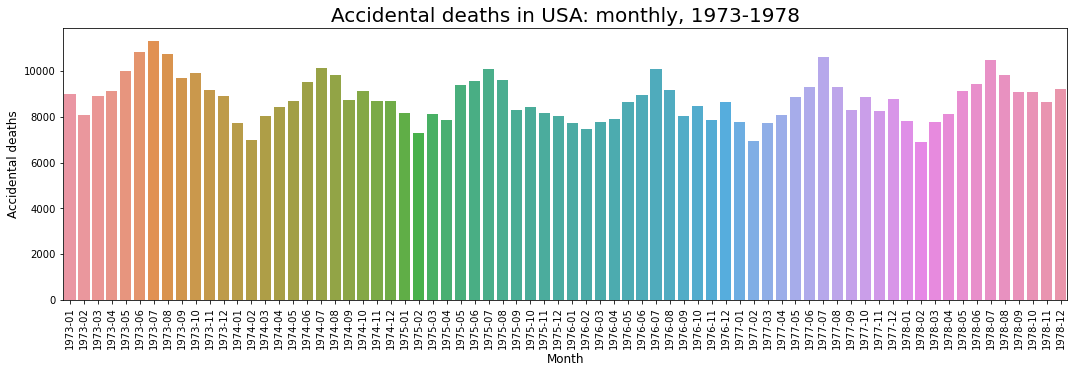

In [3]:
plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
fig = sns.barplot(x='Month', y='Accidental deaths in USA: monthly, 1973 ? 1978', data=df)
plt.title('Accidental deaths in USA: monthly, 1973-1978', fontsize=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Accidental deaths', fontsize=12)


### Предварительный анализ данных
Интересная зависимость: 
* Наибольшее количество случайных смертей в июле каждого года
* Наименьшее количество случайных смертей в феврале (возможно, это связано с количество дней, особенно в 1976 года где разница не такая существенная)

In [4]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])
plotly_df(df, title = "Accidental deaths in USA: monthly, 1973-1978")

In [5]:
df['Accidental_deaths'] = df['Accidental deaths in USA: monthly, 1973 ? 1978']
df = df.drop(['Accidental deaths in USA: monthly, 1973 ? 1978'], axis=1)

In [6]:
df

,Accidental_deaths
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017
...,...
1978-08-01,9827
1978-09-01,9110
1978-10-01,9070


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1973-01-01 to 1978-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Accidental_deaths  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


In [8]:
df.describe()

,Accidental_deaths
count,72.000000
mean,8787.736111
std,958.338013
min,6892.000000
25%,8089.000000
50%,8728.500000
75%,9323.250000
max,11317.000000


### Движение и сглаживание

In [9]:
def moving_average(series, n):
    return np.average(series[-n:])
moving_average(df.Accidental_deaths, 12) # посмотрим на прогноз, построенный по последнему наблюдаемому году (12 месяцев)

8796.75

In [10]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean()
    
    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

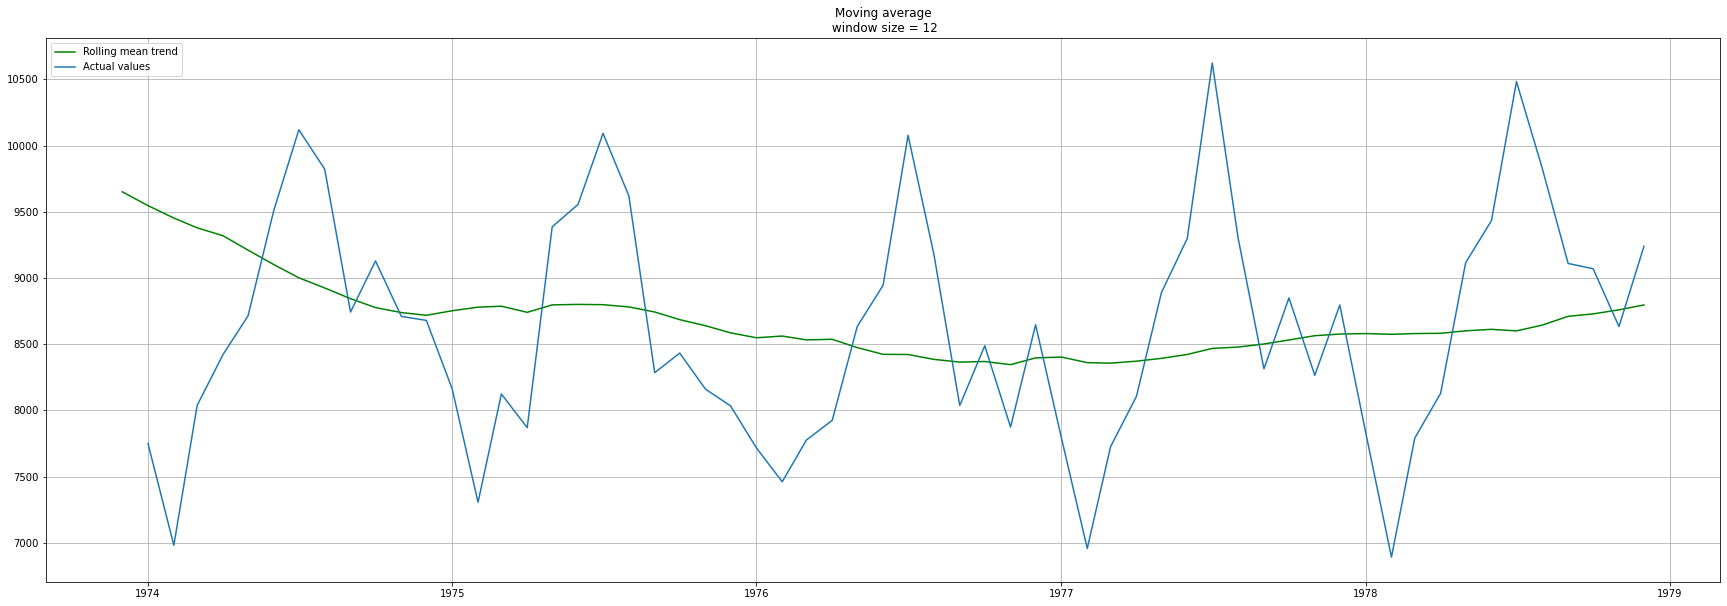

In [11]:
# сглаживаем по годам
plotMovingAverage(df, 12) 

### Экспоненциальное сглаживание

Вес  𝛼  называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше  𝛼 , тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд.

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем  (1−𝛼)  на предыдущее модельное значение, которое, в свою очередь, также содержало в себе  (1−𝛼) , и так до самого начала.

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
#Это одно из разновидностей фильтрации (см. Фильтр Калмана - в том числе сингалов)

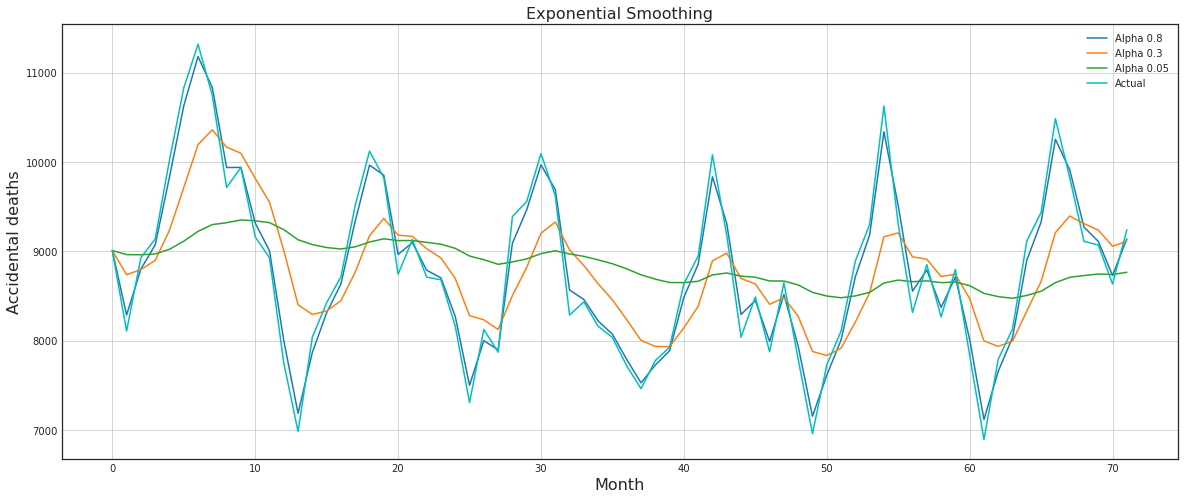

In [13]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.8,0.3,0.05]:
        plt.plot(exponential_smoothing(df.Accidental_deaths, alpha), label="Alpha {}".format(alpha))
    plt.plot(df.Accidental_deaths.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing", fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('Accidental deaths', fontsize=16)
    plt.grid(True)

### Двойное экспоненциальное сглаживание

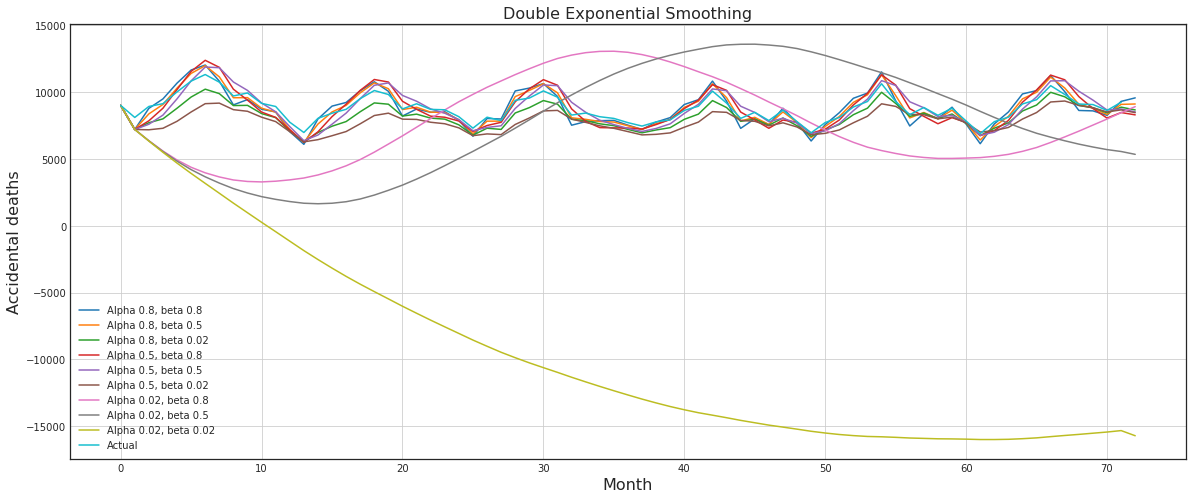

In [14]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.8, 0.5,0.02]:
        for beta in [0.8, 0.5,0.02]:
            plt.plot(double_exponential_smoothing(df.Accidental_deaths, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df.Accidental_deaths.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing", fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('Accidental deaths', fontsize=16)
    plt.grid(True)

Теперь настраивать пришлось уже два параметра -  𝛼  и  𝛽 . Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. А о не ручном подборе параметров расскажу чуть ниже, сразу после тройного экспоненциального сглаживания.

### Тройное экспоненциальное сглаживание a.k.a. Holt-Winters¶

𝑇  - длина сезона,  𝑑  - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. 

In [15]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
            

### Кросс-валидация на временных рядах¶

Код для кросс-валидации на временном ряду. Значение длины сезона 3 (пора года). 

In [16]:
from sklearn.model_selection import TimeSeriesSplit
counter = 0
def timeseriesCVscore(x):
    global counter
    counter+=1

    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=4) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen = 3, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [17]:
%%time
data = df.Accidental_deaths[:-24] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.24227299054491463 0.2274188172912054 0.0
CPU times: total: 859 ms
Wall time: 849 ms


In [18]:
opt

     fun: 1870800.8088845287
     jac: array([2.00350769e+02, 2.03051604e+02, 2.24740081e+05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 18
  status: 3
 success: False
       x: array([0.24227299, 0.22741882, 0.        ])

## Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 2 год вперёд (24 месяца)

In [19]:
# Передаем оптимальные значения модели, 
data = df.Accidental_deaths
model = HoltWinters(data[:-24], slen =12, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 24, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [20]:
print(mean_squared_error(data.values[-24:],model.result[-24:])**0.5)

270.6570494766388


In [21]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(20, 8))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-24, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

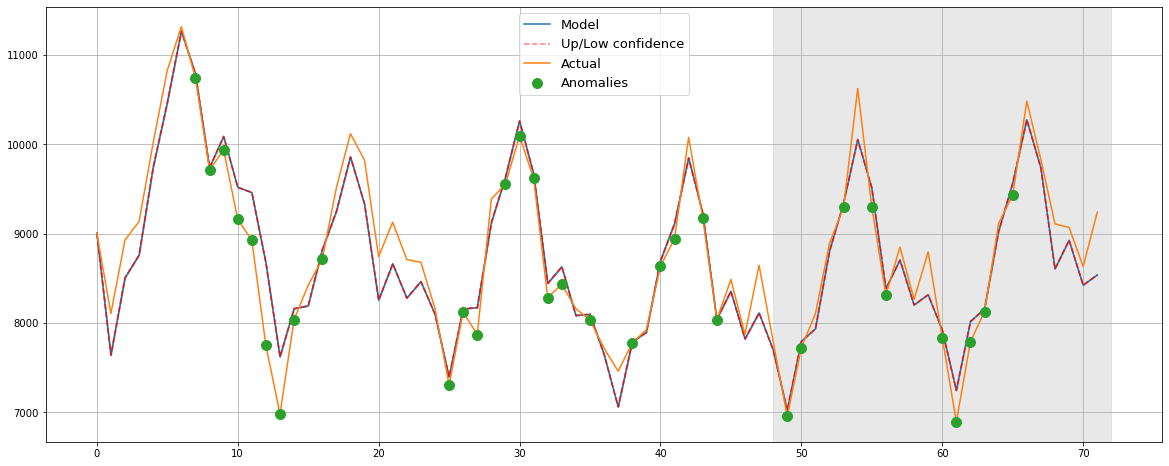

In [22]:
plotHoltWinters()

Модель описала исходный временной ряд не совсем точно, но уловила сезонность.

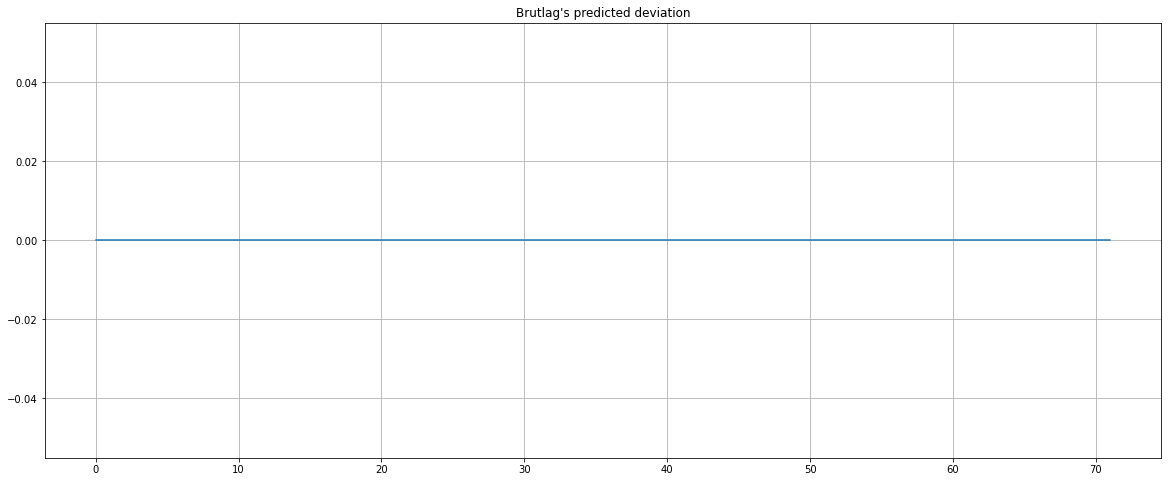

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### Предсказание количества смертей на следующие 2 года.

In [24]:
sum(model.result[-24:])

206207.6417140578

### Эконометрический подход

In [25]:
def tsplot(y, lags=None, figsize=(16, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.102481


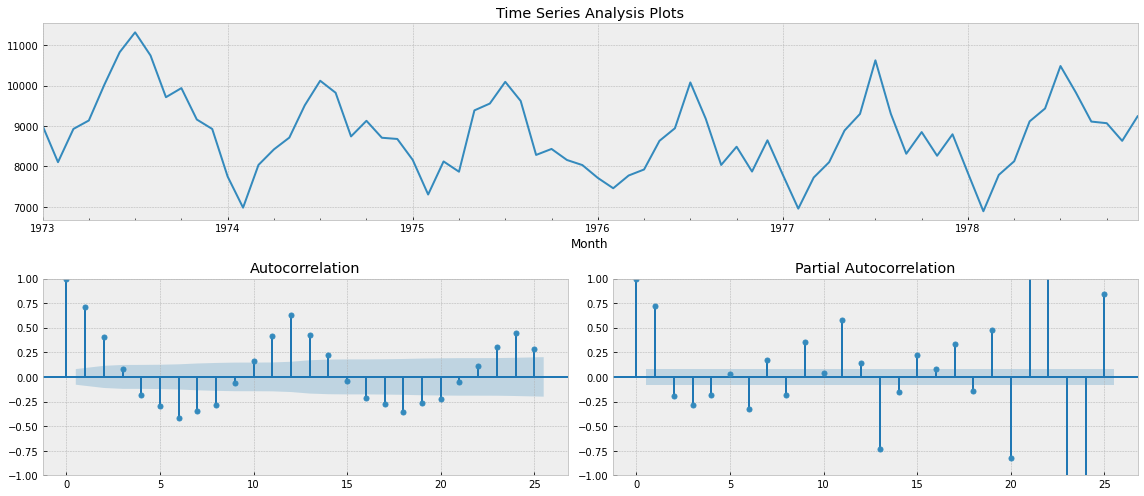

In [26]:
tsplot(df.Accidental_deaths, lags=25)

Исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса

Критерий Дики-Фуллера: p=0.086943
Оптимальный параметр преобразования Бокса-Кокса: -0.275376


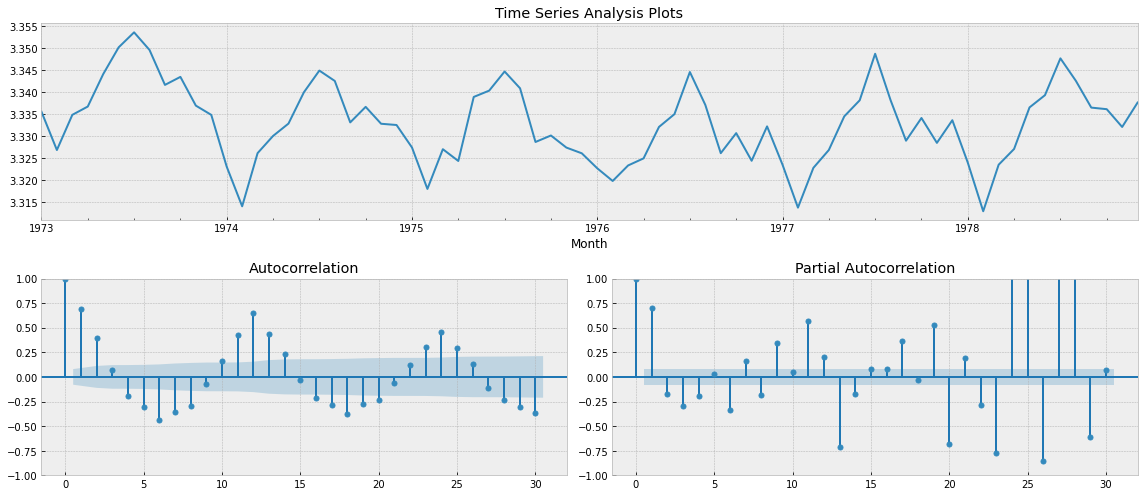

In [27]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = df.copy()
data['deaths_box'], lmbda = scs.boxcox(data.Accidental_deaths+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.deaths_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Стало лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.005633


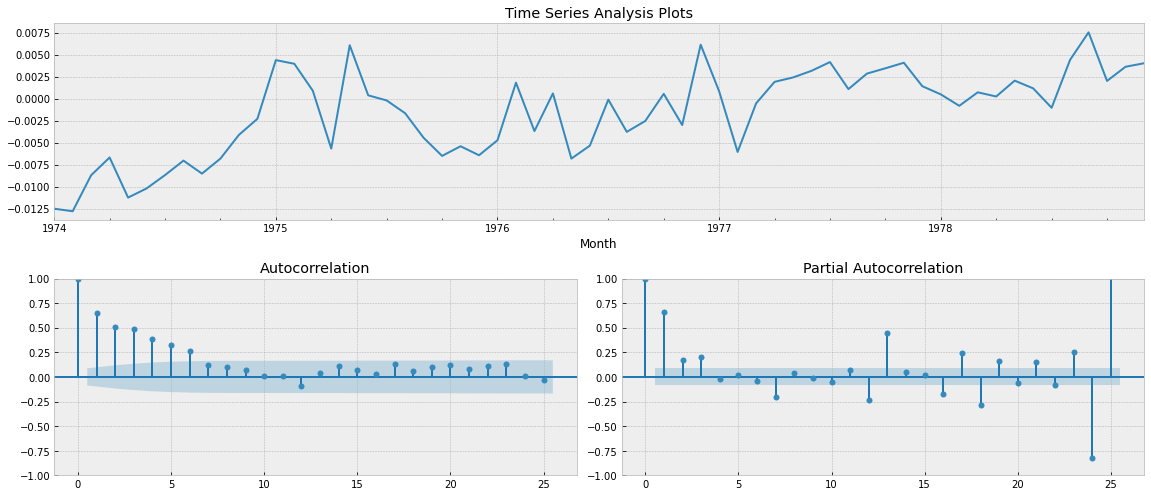

In [28]:
data['deaths_box_season'] = data.deaths_box - data.deaths_box.shift(12)
tsplot(data.deaths_box_season[3*4:], lags=25)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. 

Критерий Дики-Фуллера: p=0.004746


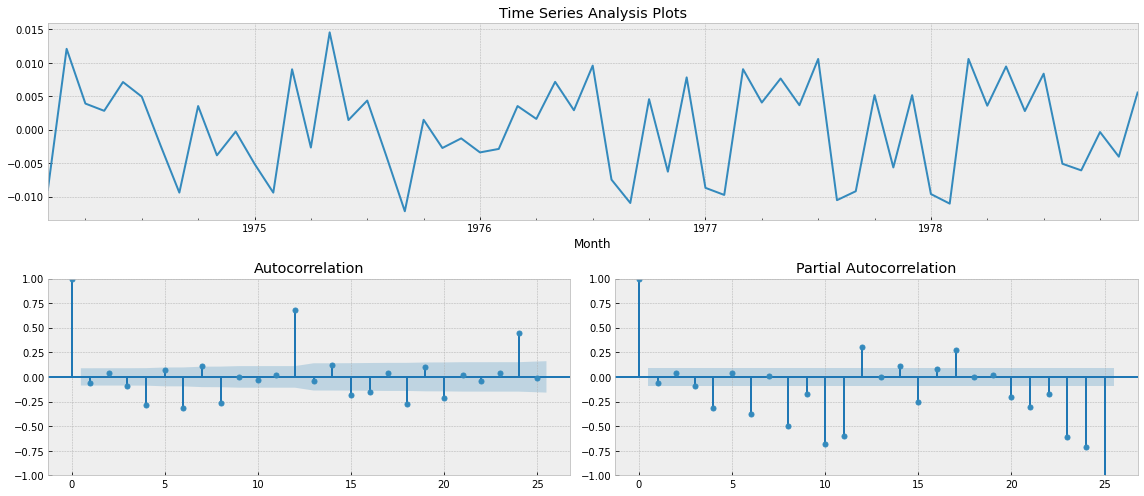

In [29]:
data['deaths_box_season'] = data.deaths_box - data.deaths_box.shift(1)
tsplot(data.deaths_box_season[3*4+1:], lags=25)

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [30]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [31]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.deaths_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

CPU times: total: 1min 15s
Wall time: 22.3 s


In [32]:
%%time
best_model=sm.tsa.statespace.SARIMAX(data.deaths_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)

C:\Users\37533\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\37533\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\37533\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: total: 1min 29s
Wall time: 22.3 s


In [33]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           deaths_box   No. Observations:                   72
Model:             SARIMAX(4, 1, 3)x(4, 1, [1], 24)   Log Likelihood                 194.969
Date:                              Thu, 12 Jan 2023   AIC                           -363.937
Time:                                      14:43:01   BIC                           -339.885
Sample:                                  01-01-1973   HQIC                          -354.886
                                       - 12-01-1978                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6678      0.394     -1.697      0.090      -1.439       0.104
ar.L2         -0.76

Критерий Дики-Фуллера: p=0.000000


C:\Users\37533\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



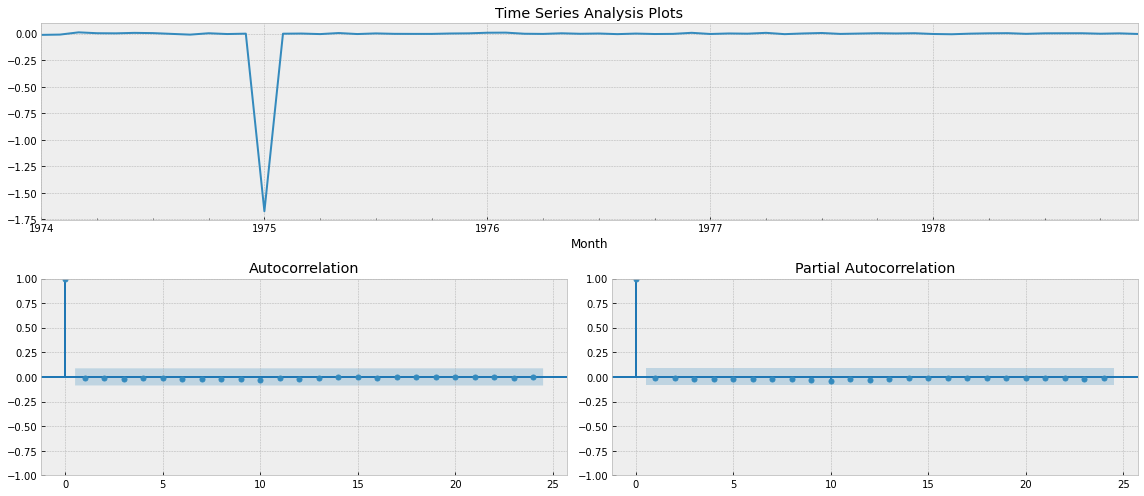

In [34]:
tsplot(best_model.resid[12:], lags=24)

C:\Users\37533\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log

C:\Users\37533\AppData\Local\Temp\ipykernel_2992\2417882547.py:3: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



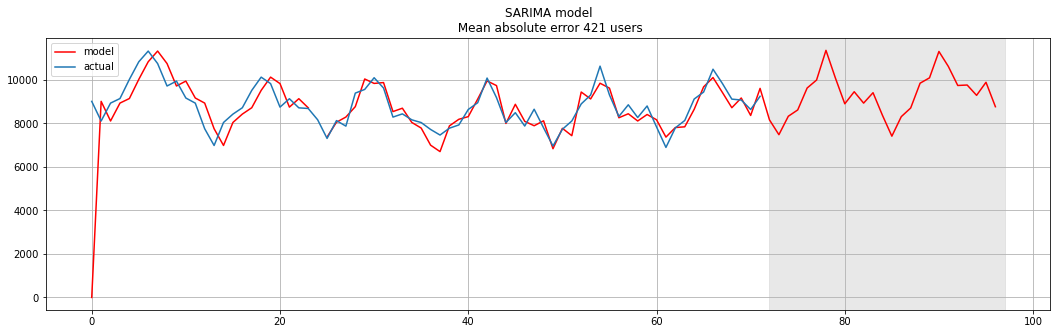

In [42]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+24), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Accidental_deaths.values[-400:]
plt.figure(figsize=(18, 5))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Accidental_deaths, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

### Достаточно похоже получился прогноз.